# Installing and Importing Libraries

In [1]:
# Installing some Important Libraries
! pip install pyspark               
! pip install pyspellchecker        
! pip install scattertext
! pip install nltk
! pip install -U kaleido
! pip install twython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812366 sha256=9c250f7622af525d29828aedc275d48c97d696c5c67038dbea1e6daf2b6f9a9b
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 47.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 14.2 MB/s eta 0:00:00:00:0100:01


In [2]:
# Importing Data Preprocessing and Wrangling libraries
import os                             
import pandas as pd
import random
import re
from tqdm.notebook import tqdm
import pandas as pd 
import numpy as np
from datetime import datetime
import dateutil.parser

# Importing NLP Libraries
import nltk
from spellchecker import SpellChecker
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.corpus import stopwords


# Importing Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.offline as pyo 
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import scattertext as st
from IPython.display import IFrame
from wordcloud import WordCloud, ImageColorGenerator

# Importing some pyspark libraries for data processing  and data wrangling
from pyspark.sql.functions import col
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, mean, sum as pyspark_sum, lit, hour, when, unix_timestamp, dayofweek, min, max, year
from pyspark.sql.types import StringType, DoubleType, ArrayType
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, lit, when, col
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns",None)   # setting for showing max columns


# Downloading periphrals
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Intializate our tools 
sns.set_style('darkgrid')

# For sentiment analysis 
sia = SIA() 

# To identify misspelled words
spell = SpellChecker() 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Initializing the SparkSession with 3G executor and driver memory
spark = SparkSession.builder \
    .appName("Tesla_Tweets") \
    .config("spark.executor.memory", "3g") \
    .config("spark.driver.memory", "3g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/26 20:25:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Loading Data

In [4]:
# Loading raw Data Set in spark dataframe
df = spark.read.csv("/kaggle/input/tesla-data-tweets-1/Tesla_Tweets_Data.csv", header=True, inferSchema = True)

In [5]:
df.show(5)          # visualising first five rows of dataset

+-------+--------------------+--------------------+------------+--------------------+-------------------+
|Keyword|             content|      conversationId|retweetCount|           tweet_url|               date|
+-------+--------------------+--------------------+------------+--------------------+-------------------+
|  TESLA|@jpr007 @TaylorOg...|1.457343880219742...|         0.0|https://twitter.c...|2024-07-07 23:59:55|
|  TESLA|@DMC_Ryan @Tesla ...|1.457407500974624...|         0.0|https://twitter.c...|2024-07-07 23:59:41|
|  TESLA|@the_other_johnd ...|1.457476707242451...|         0.0|https://twitter.c...|2024-07-07 23:59:40|
|  TESLA|Elon Musk's Twitt...|1.457498009126723...|         4.0|https://twitter.c...|2024-07-07 23:59:39|
|  TESLA|@donutmavenfox Go...|1.457104039359942...|         0.0|https://twitter.c...|2024-07-07 23:59:36|
+-------+--------------------+--------------------+------------+--------------------+-------------------+
only showing top 5 rows



In [6]:
# Getting the number of rows in the dataset
num_rows1 = df.count()

# Getting the number of columns in the dataset
num_cols1 = len(df.columns)

print(f"Number of rows in the Dataset: {num_rows1}")
print(f"Number of columns in the Dataset: {num_cols1}")

Number of rows in the Dataset: 468405
Number of columns in the Dataset: 6


In [7]:
# Getting summary statistics for columns in the dataset
df.describe().show()

24/08/26 20:25:37 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|             Keyword|             content|      conversationId|        retweetCount|           tweet_url|                date|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  count|              468392|              407508|              328693|              326327|              325627|              265146|
|   mean|5.529990266882711E88|1.437311072054367...|1.183196812738088...|  1.9707580132515E16|3.815160413941613...|3.831845514921127...|
| stddev|7.103401113586288E89|1.755773672914962...|5.711367715329017E17|1.684317381142814...|6.412045811983562...|6.416602159408538...|
|    min|                    |                    |                    |                    |                    |               greed|
|    max|🪶 Nikola Tesla h...|🪡 i was talking ...

In [8]:
# Getting data type info for columns in the dataset
df.printSchema()

root
 |-- Keyword: string (nullable = true)
 |-- content: string (nullable = true)
 |-- conversationId: string (nullable = true)
 |-- retweetCount: string (nullable = true)
 |-- tweet_url: string (nullable = true)
 |-- date: string (nullable = true)



# Data Preprocessing

In [9]:
# Dropping the 'Keyword','conversationId','retweetCount','tweet_url' column as these are unecessary columns
df = df.drop('Keyword')
df = df.drop('conversationId')
df = df.drop('retweetCount')
df = df.drop('tweet_url')
# Getting the number of columns in the dataset after droppig some columns
num_cols_drop = len(df.columns)
print(f"Number of columns in Dataset after dropping unecessary columns: {num_cols_drop}")

Number of columns in Dataset after dropping unecessary columns: 2


In [10]:
# Checking for null values in each column and creating a DataFrame with the counts for the dataset
null_counts = df.select([pyspark_sum(col(column).isNull().cast("int")).alias(column) for column in df.columns])

null_counts_list = [(column, null_counts.select(column).collect()[0][0]) for column in df.columns]
null_counts_df = spark.createDataFrame(null_counts_list, ["Column", "MissingValues"])

# Displaying the null counts in the dataset
null_counts_df.show()

+-------+-------------+
| Column|MissingValues|
+-------+-------------+
|content|        60897|
|   date|       203259|
+-------+-------------+



In [11]:
# Dropping null values from the dataset
df = df.dropna()

In [12]:
# Getting the number of rows in the datasets after dropping null
num_rows1 = df.count()

print(f"Number of rows in the Dataset: {num_rows1}")

Number of rows in the Dataset: 265141


In [13]:
# Checking for duplicate rows in the datasets
# Showing duplicate rows in the dataset
duplicate_rows_data1 = df.groupBy(df.columns).count().filter(F.col("count") > 1)
duplicate_rows_data1.show()

# Dropping duplicate rows from the data
df = df.dropDuplicates()


# Getting the number of rows in the datasets
num_rows1 = df.count()

# Getting the number of columns in the datasets
num_cols1 = len(df.columns)


print(f"Number of rows in the Dataset: {num_rows1}")
print(f"Number of columns in the Dataset: {num_cols1}")

+-------------------------+--------------------+-----+
|                  content|                date|count|
+-------------------------+--------------------+-----+
|          great Community| #LazyLions and m...|    2|
|                    $MARA|                $LEN|    2|
|      Tesla CEO Elon M...|                 0.0|    2|
|     "Elon Musk spars ...|                 0.0|    2|
|           Chevrolet BOLT|       Jaguar I-PACE|    2|
|                 you know|                 0.0|    2|
|     """Je ne peux pas...|                 0.0|    2|
|               000 tokens|                 0.0|    7|
|     @elonmusk @Rainma...| 2024-07-12 13:12:14|    2|
|     737 shares of the...|                 0.0|    2|
|     """If you only kn...|                 0.0|    2|
|      potential merger...|                 0.0|    2|
|     "Insider: ""Alarm...|                 0.0|    2|
|                   """Moi| aucune rémunérat...|    2|
|     """Much is made l...|                 0.0|    2|
|         

Number of rows in the Dataset: 265005
Number of columns in the Dataset: 2


In [14]:
# Renaming the 'content' column to 'text'
df = df.withColumnRenamed('content', 'text')

In [15]:
# Converting 'date' column to datetime and create new columns for year, month, and hour
df = df.withColumn('Year', F.year('date')) \
           .withColumn('month', F.month('date')) \
           .withColumn('hour', F.hour('date'))

# Showing the DataFrame after adding new columns
data = df.toPandas()
df.show(5)

+--------------------+-------------------+----+-----+----+
|                text|               date|Year|month|hour|
+--------------------+-------------------+----+-----+----+
|Elon Musk dumps $...|2024-07-13 23:51:04|2024|    7|  23|
|@alex_locke15 @Va...|2024-07-13 23:40:08|2024|    7|  23|
|@WholeMarsBlog Ch...|2024-07-13 23:09:39|2024|    7|  23|
|Todos queremos en...|2024-07-13 22:50:00|2024|    7|  22|
|@AdrianEliaskkkk ...|2024-07-13 22:04:27|2024|    7|  22|
+--------------------+-------------------+----+-----+----+
only showing top 5 rows



# Text Preprocessing

In [16]:
data['datetime'] = data['date']
data['datetime'] = pd.to_datetime(data['datetime'],  errors='coerce')   #changing data type of Date into datetime format

# standardizing tweets preprocessing (lower casing all tweets)
data.text = data.text.str.lower()
#Removing twitter handlers
data.text = data.text.apply(lambda x:re.sub('@[^\s]+','',x))
#removing hashtags
data.text = data.text.apply(lambda x:re.sub(r'\B#\S+','',x))
# Removing URLS
data.text = data.text.apply(lambda x:re.sub(r"http\S+", "", x))
# Removing all the special characters
data.text = data.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))
#removing all single characters
data.text = data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
# Substituting multiple spaces with single space
data.text = data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

# converting the 'date' column to datetime format and remove the timezone information
data['datetime'] = pd.to_datetime(data['datetime']).dt.tz_localize(None)

# Sentiment Analysis 

In [17]:
# Function to extract sentiments from the cleaned texts
def label_sentiment(x:float):
    if x < 0.00 : return 'negative'
    if x > 0.00 : return 'positive'
    return 'neutral'

# Feature Extraction
data['words'] = data.text.apply(lambda x:re.findall(r'\w+', x ))
data['errors'] = data.words.apply(spell.unknown)
data['errors_count'] = data.errors.apply(len)
data['words_count'] = data.words.apply(len)
data['sentence_length'] = data.text.apply(len)
data['hour'] = data.datetime.apply(lambda x: x.hour)
data['month'] = data.datetime.apply(lambda x: x.month)


# Extracting Sentiment Values for each tweet 
data['sentiment'] = [sia.polarity_scores(x)['compound'] for x in tqdm(data['text'])]
data['overall_sentiment'] = data['sentiment'].apply(label_sentiment)
data = data.drop(['errors'], axis =1)
spark_df1 = spark.createDataFrame(data)
data = spark_df1


# Casting 'Year', 'Month', and 'Hour' columns to IntegerType
data = data.withColumn('Year', col('Year').cast('int')) \
       .withColumn('Month', col('Month').cast('int')) \
       .withColumn('Hour', col('Hour').cast('int'))

# Showing the new DataFrame
df = data.toPandas()
data.show(5)

  0%|          | 0/265005 [00:00<?, ?it/s]

24/08/26 20:28:19 WARN TaskSetManager: Stage 37 contains a task of very large size (19190 KiB). The maximum recommended task size is 1000 KiB.
24/08/26 20:28:37 WARN TaskSetManager: Stage 38 contains a task of very large size (19190 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-------------------+----+-----+----+-------------------+--------------------+------------+-----------+---------------+---------+-----------------+
|                text|               date|Year|Month|Hour|           datetime|               words|errors_count|words_count|sentence_length|sentiment|overall_sentiment|
+--------------------+-------------------+----+-----+----+-------------------+--------------------+------------+-----------+---------------+---------+-----------------+
|elon musk dumps 1...|2024-07-13 23:51:04|2024|    7|  23|2024-07-13 23:51:04|[elon, musk, dump...|           4|         13|             75|  -0.4019|         negative|
|apple is popular ...|2024-07-13 23:40:08|2024|    7|  23|2024-07-13 23:40:08|[apple, is, popul...|           0|         14|             83|   0.6908|         positive|
|chinacoming withs...|2024-07-13 23:09:39|2024|    7|  23|2024-07-13 23:09:39|[chinacoming, wit...|           4|         28|            172|   0.0516|     

# Exploratory Data Analysis

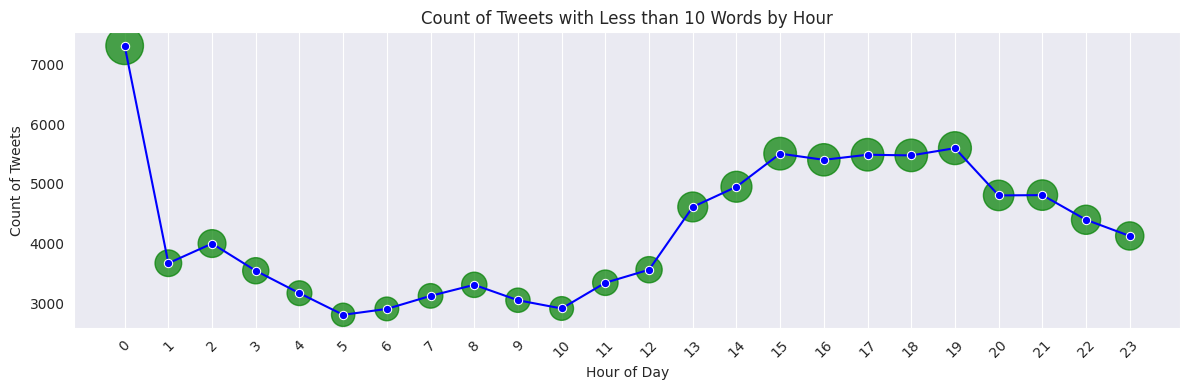

In [18]:
# Filtering tweets with fewer than 10 words
df_filtered = df[df['words_count'] < 10]

# Counting the number of such tweets per hour
tweet_counts = df_filtered.groupby('Hour').size().reset_index(name='Count')

# Plotting the line bubble scatter plot
plt.figure(figsize=(12, 4))

sns.lineplot(x='Hour', y='Count', data=tweet_counts, color='blue', marker='o')

# Adding scatter plot for the bubble effect
plt.scatter(x=tweet_counts['Hour'], y=tweet_counts['Count'], s=tweet_counts['Count']*0.1, alpha=0.7, color='green')

# Customizing the plot
plt.title('Count of Tweets with Less than 10 Words by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Count of Tweets')
plt.xticks(range(24))  
plt.xticks(rotation=45)
plt.grid(axis='y')

# Showing the plot
plt.tight_layout()
plt.show()


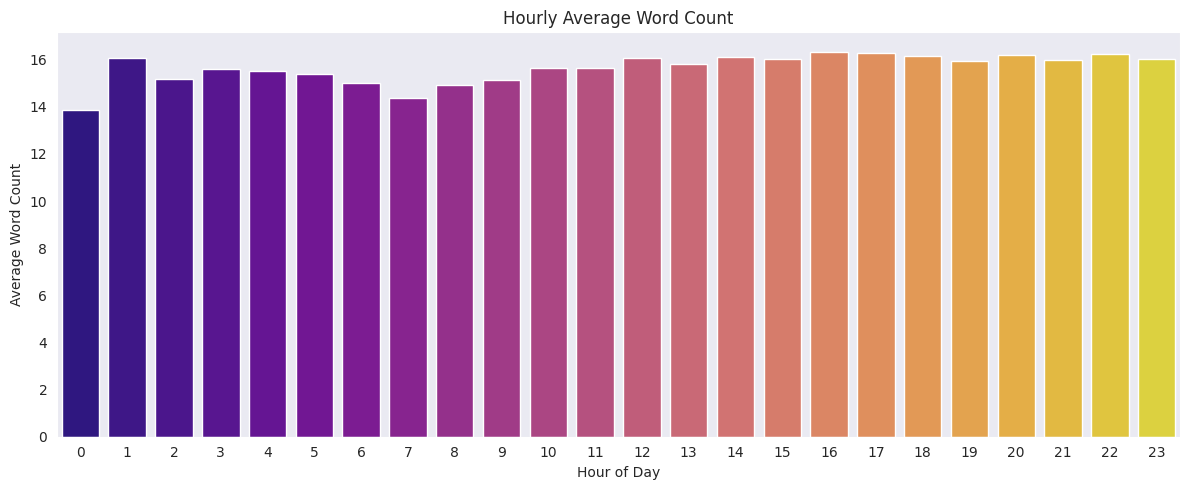

In [19]:
# Calculating hourly average word count
hourly_word_count = df.groupby('Hour')['words_count'].mean().reset_index(name='Average_Word_Count')

# Customizing plot size and color palette
fig_size = (12, 5)  
color_palette = 'plasma'  

# Create plot
plt.figure(figsize=fig_size)
sns.barplot(x='Hour', y='Average_Word_Count', data=hourly_word_count, palette=color_palette)

# Customizing the plot
plt.title('Hourly Average Word Count')
plt.xlabel('Hour of Day')
plt.ylabel('Average Word Count')
plt.xticks(range(24))  
plt.grid(axis='y')

# Displaying the plot
plt.tight_layout()
plt.show()


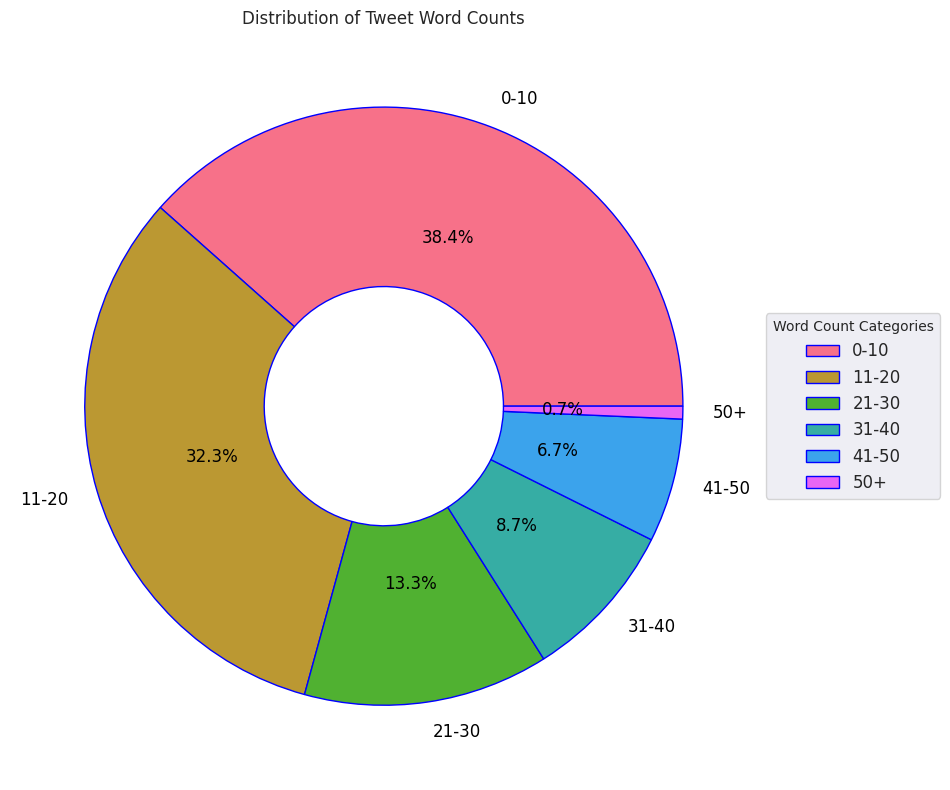

In [20]:
# Defining bins for the word count categories
bins = [0, 10, 20, 30, 40, 50, df['words_count'].max()]
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '50+']
df['word_count_category'] = pd.cut(df['words_count'], bins=bins, labels=labels, right=False)

# Calculating the proportion of each category
category_counts = df['word_count_category'].value_counts()
category_proportions = category_counts / category_counts.sum()

# Setting the figure size 
fig_size = (10, 8)  
fig, ax = plt.subplots(figsize=fig_size, subplot_kw=dict(aspect="equal"))

# Donut plot 
colors = sns.color_palette('husl', len(category_proportions)) 

wedges, texts, autotexts = ax.pie(
    category_proportions,
    labels=category_proportions.index,
    autopct='%1.1f%%',
    colors=colors,
    wedgeprops=dict(width=0.6, edgecolor='b'),  
    textprops=dict(color='black', fontsize=12)  
)

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')
    autotext.set_horizontalalignment('center')

# Adding legends
ax.legend(
    wedges,
    category_proportions.index,
    title='Word Count Categories',
    loc='center left',
    bbox_to_anchor=(1, 0, 0.6, 1),
    fontsize='12'
)

# Customizing the plot
ax.set_title('Distribution of Tweet Word Counts')

# Displaying the donut plot
plt.tight_layout()
plt.show()

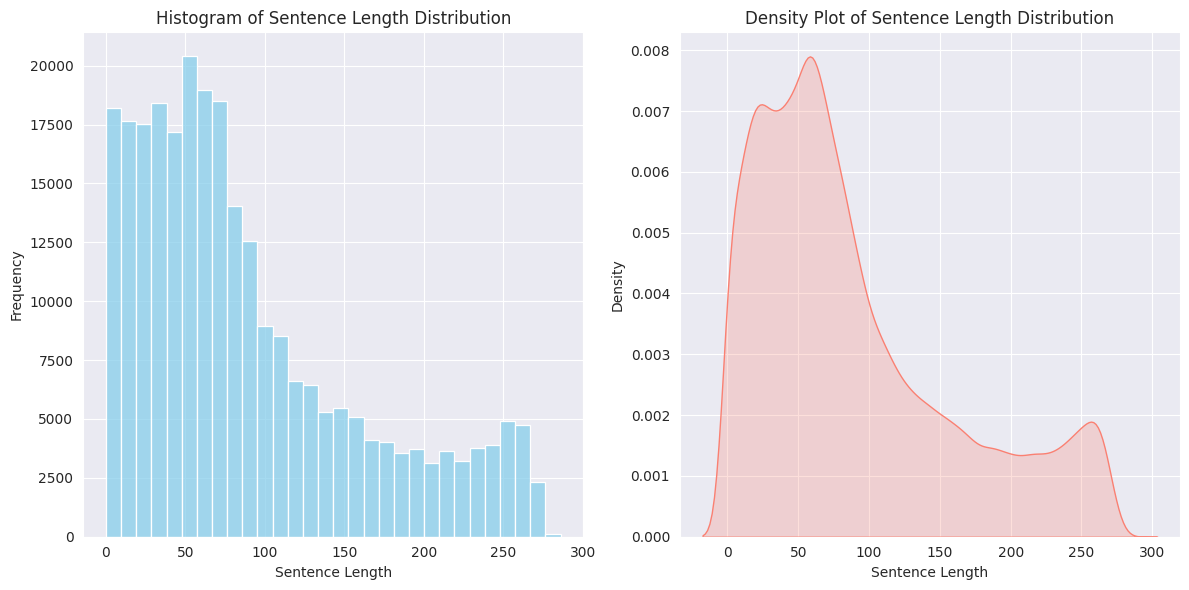

In [21]:
# Customizing plot size and color palette
fig_size = (12, 6)  
color_palette = 'coolwarm'  

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=fig_size)

# Plotting histogram of sentence length distribution
sns.histplot(df['sentence_length'], bins=30, kde=False, color='skyblue', ax=axes[0])
axes[0].set_title('Histogram of Sentence Length Distribution')
axes[0].set_xlabel('Sentence Length')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plotting density plot of sentence length distribution
sns.kdeplot(df['sentence_length'], fill=True, color='salmon', ax=axes[1])
axes[1].set_title('Density Plot of Sentence Length Distribution')
axes[1].set_xlabel('Sentence Length')
axes[1].set_ylabel('Density')
axes[1].grid(True)

# Adjusting layout
plt.tight_layout()
plt.show()


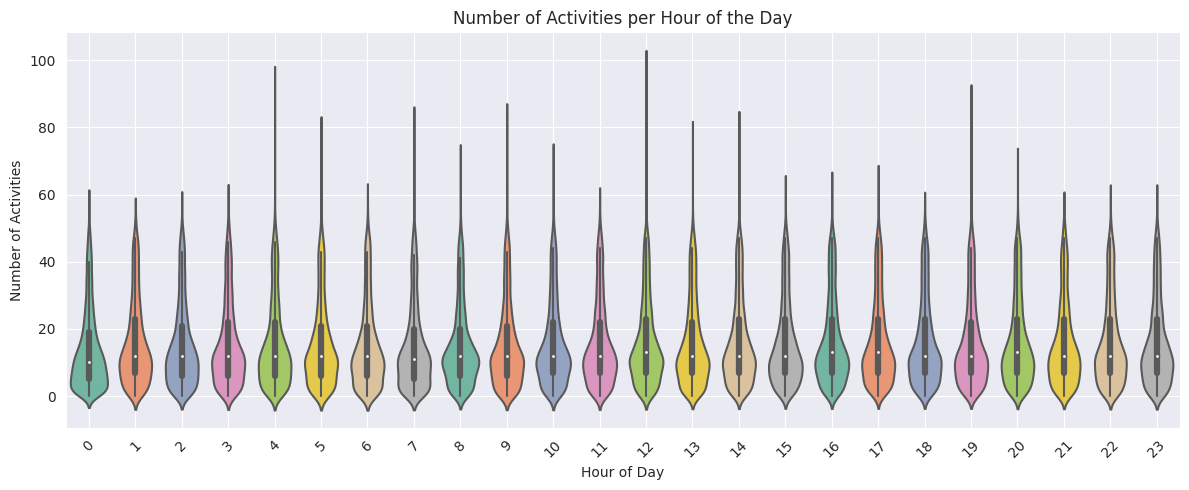

In [22]:
df['Hour'] = df['Hour'].astype('category')

# Creating a violin plot of the number of activities per hour
fig_size = (12, 5)  
plt.figure(figsize=fig_size)

sns.violinplot(x='Hour', y='words_count', data=df, palette='Set2')

# Customizing the plot
plt.title('Number of Activities per Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Activities')
plt.xticks(rotation=45)  
plt.grid(True)

# Displaying the plot
plt.tight_layout()
plt.show()


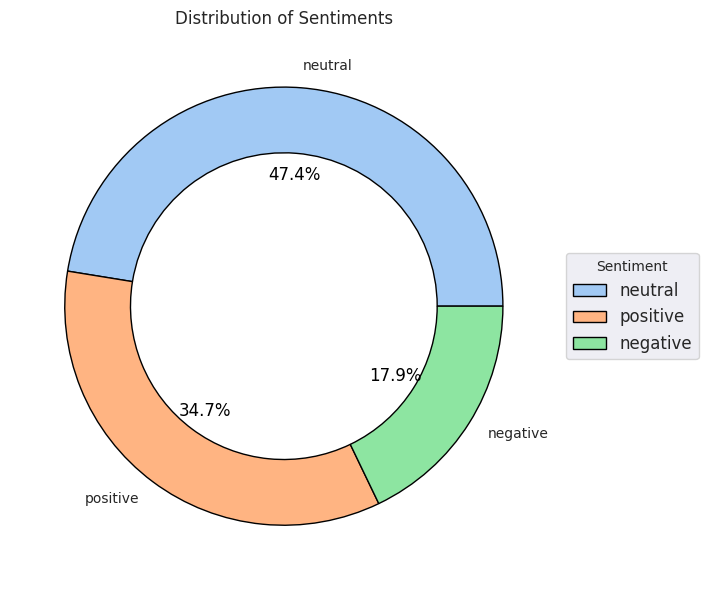

In [23]:
df_copy = df
# Calculating the proportion of each sentiment
sentiment_counts = df_copy['overall_sentiment'].value_counts()
sentiment_proportions = sentiment_counts / sentiment_counts.sum()

# Create the pie plot
fig_size = (8, 6)  
fig, ax = plt.subplots(figsize=fig_size)

wedges, texts, autotexts = ax.pie(
    sentiment_proportions,
    labels=sentiment_proportions.index,
    autopct='%1.1f%%',
    colors=sns.color_palette('pastel', len(sentiment_proportions)),  
    wedgeprops=dict(width=0.3, edgecolor='black') 
)

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')
    autotext.set_horizontalalignment('center')

ax.legend(
    wedges,
    sentiment_proportions.index,
    title='Sentiment',
    loc='center left',
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize='12'
)

# Customizing the plot
ax.set_title('Distribution of Sentiments')

# Displaying the  plot
plt.tight_layout()
plt.show()


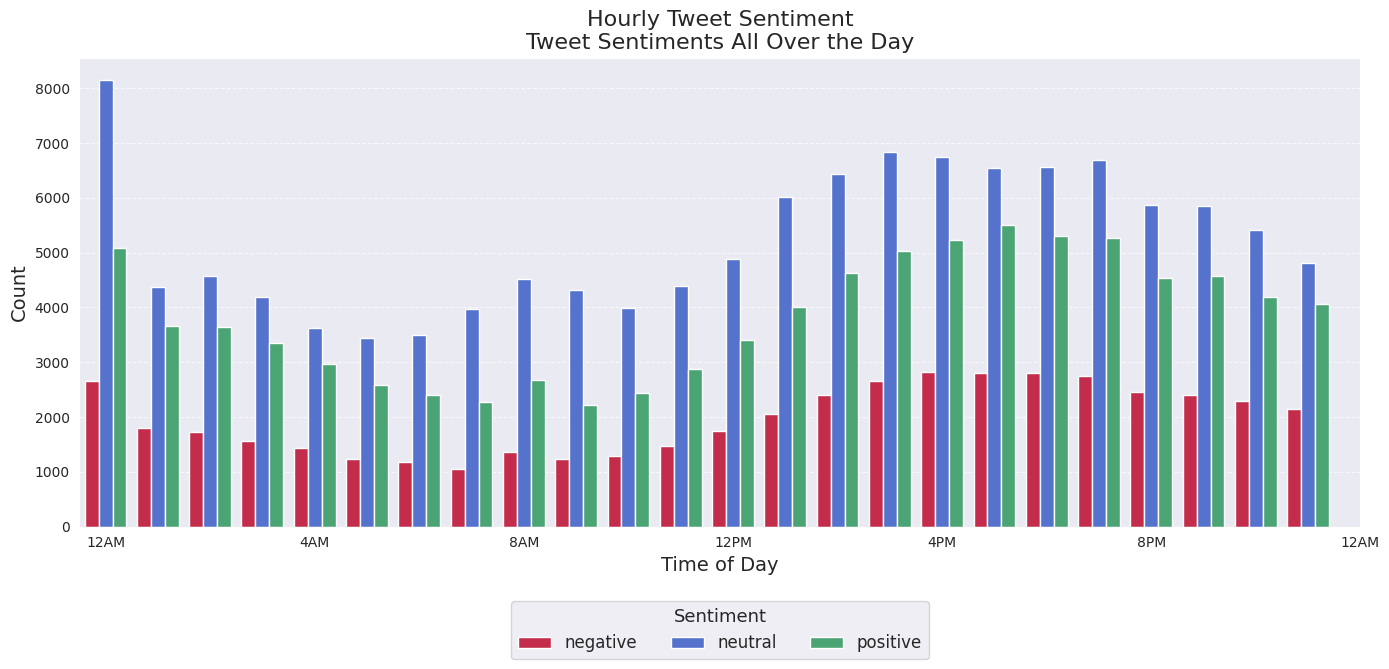

In [24]:
df_copy = df

# Preparing the data
sentiment_over_time = df_copy.sort_values('Hour')[['Hour', 'sentiment', 'overall_sentiment']]
annual_sentiment = pd.DataFrame(sentiment_over_time.groupby(['Hour', 'overall_sentiment']).size(), columns=['Count']).reset_index()

fig_size = (14, 7)  
palette = {'positive': 'mediumseagreen', 'negative': 'crimson', 'neutral': 'royalblue'}  

plt.figure(figsize=fig_size)

# Creating bar plot
sns.barplot(x='Hour', y='Count', hue='overall_sentiment', data=annual_sentiment, palette=palette)

# Customizing the plot
plt.title('Hourly Tweet Sentiment\nTweet Sentiments All Over the Day', fontsize=16)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(
    ticks=[0, 4, 8, 12, 16, 20, 24],
    labels=['12AM', '4AM', '8AM', '12PM', '4PM', '8PM', '12AM']
)
plt.legend(title='Sentiment', title_fontsize='13', fontsize='12', loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Displaying the plot
plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


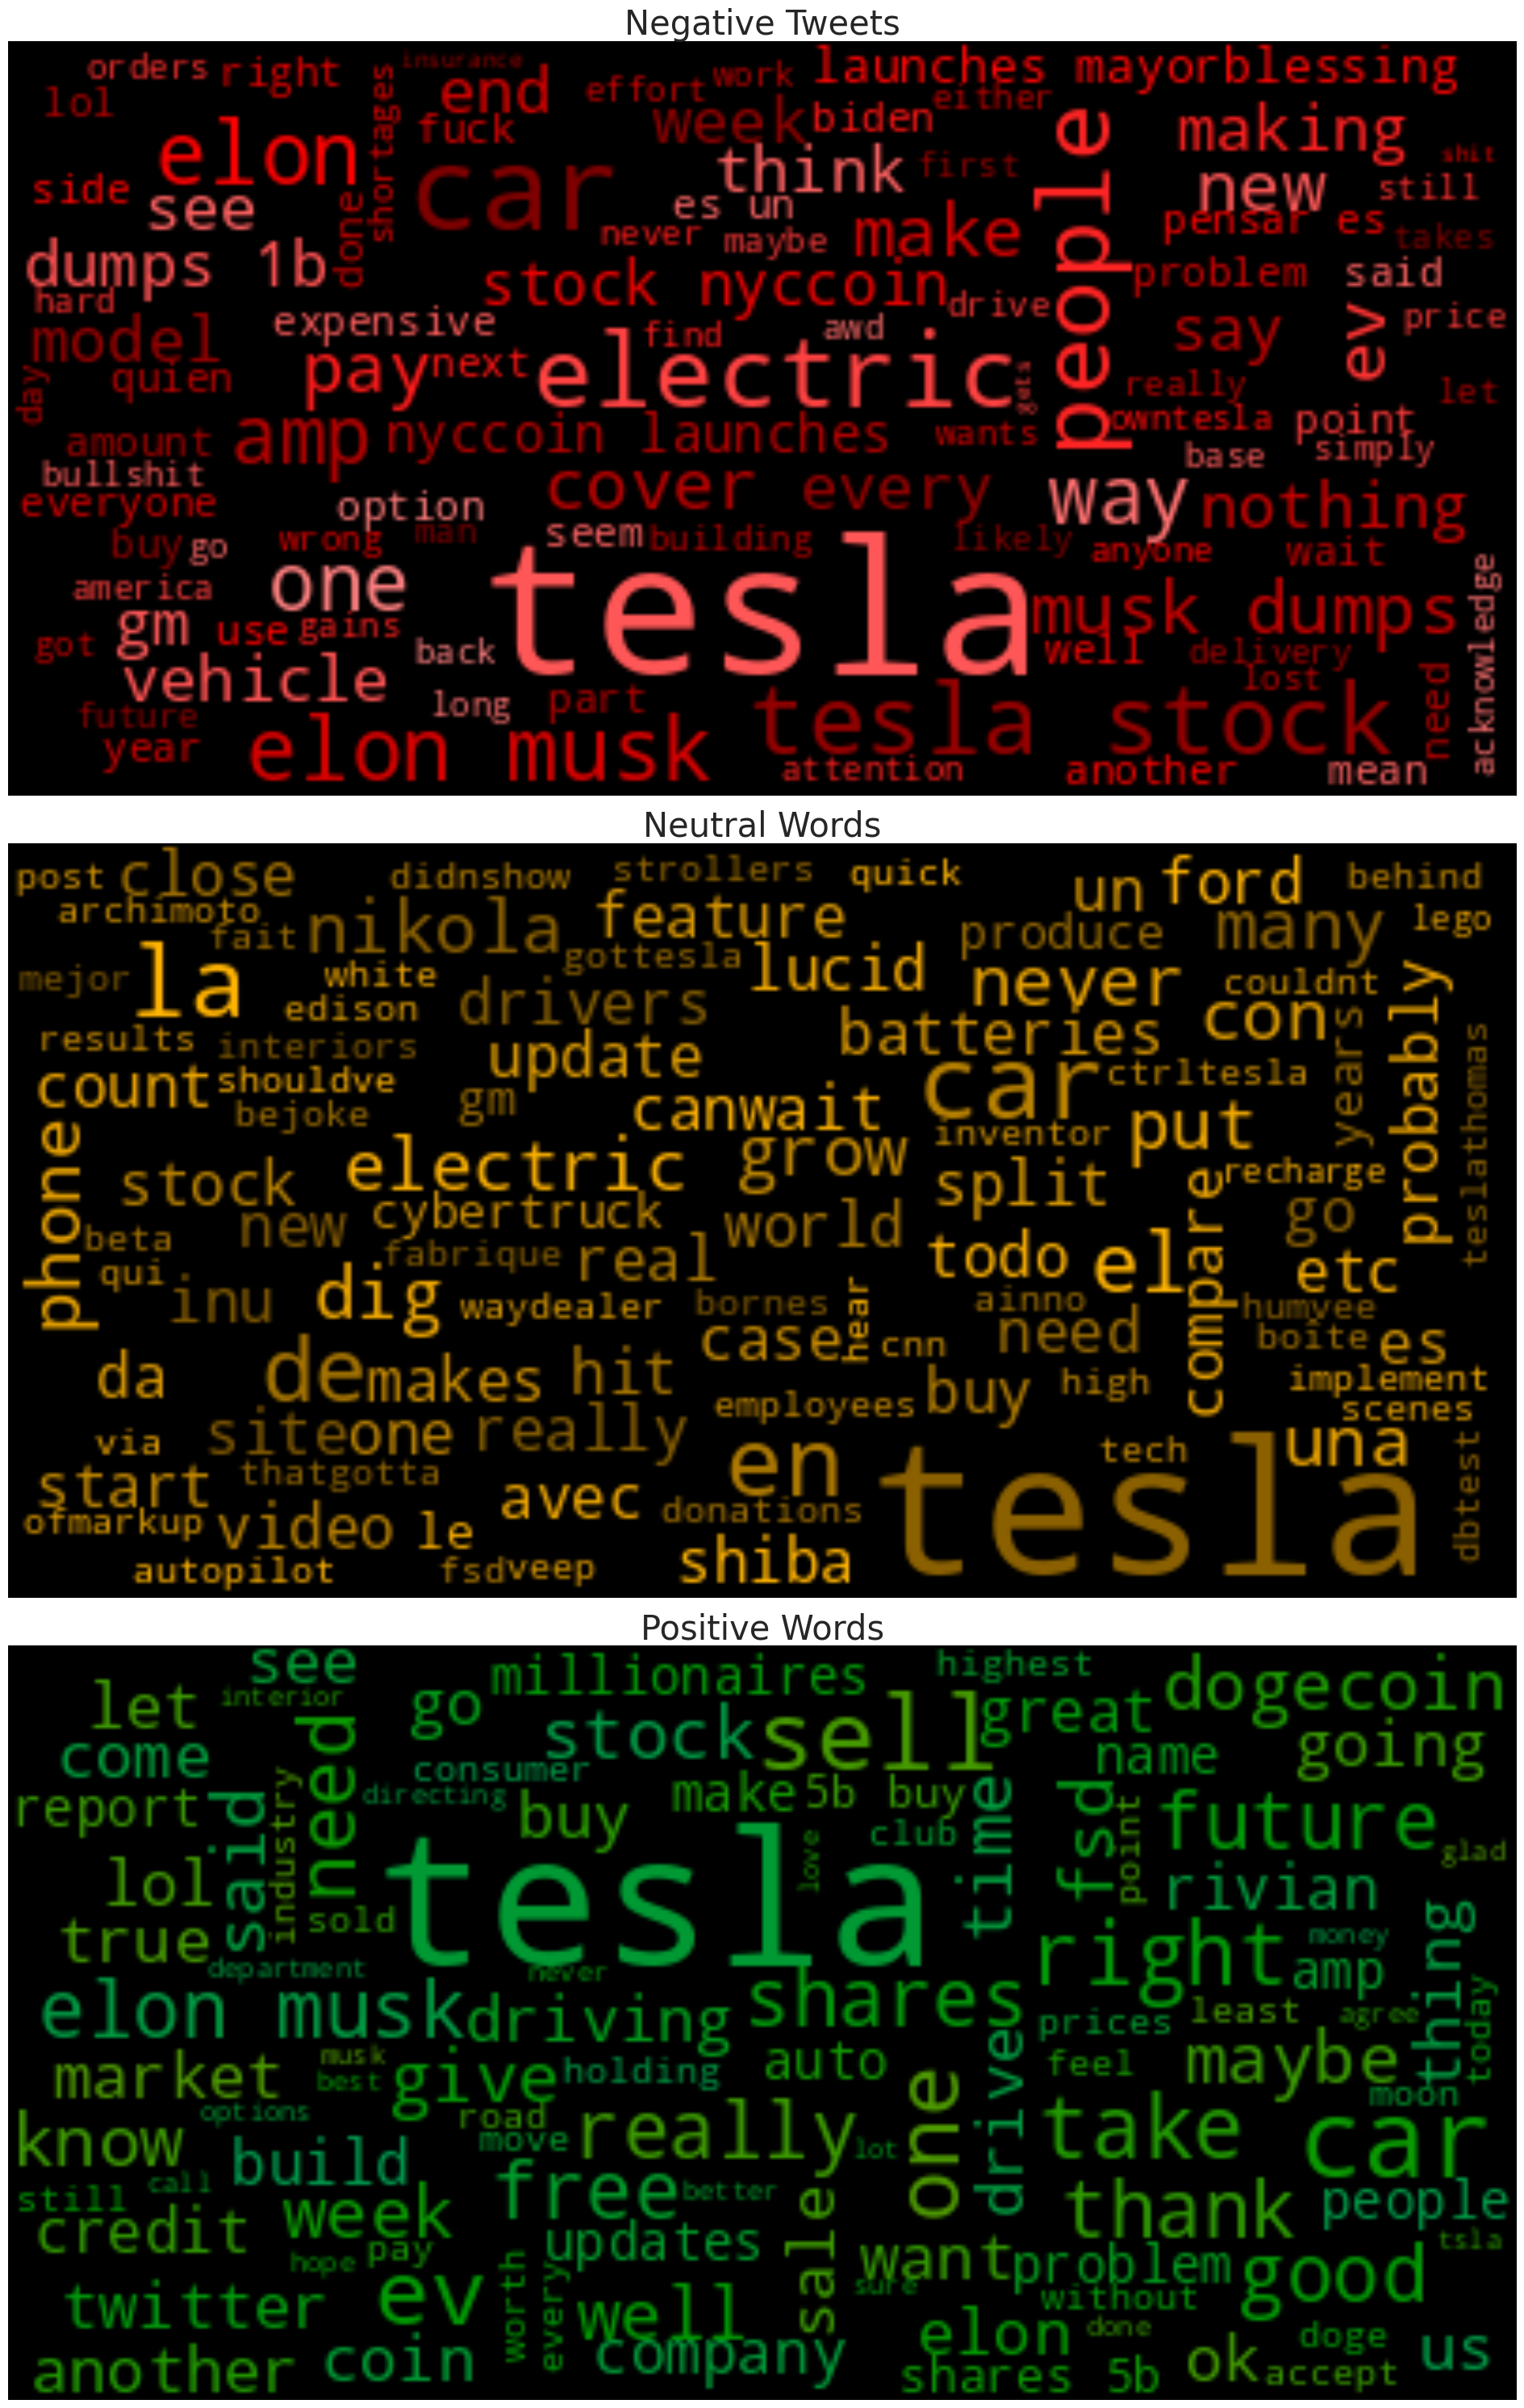

In [35]:
# Ensuring the stopwords list is downloaded
import nltk
nltk.download('stopwords')

def flatten_list(l):
    return [x for y in l for x in y]

# Color coding for word clouds 
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)"

def green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)"

def yellow_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)"

def generate_word_clouds(neg_doc, neu_doc, pos_doc):
    # Setting Seaborn style
    sns.set(style="whitegrid")

    # Creating subplots
    fig, axes = plt.subplots(3, 1, figsize=(20, 30))

    # Negative Word Cloud
    wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(" ".join(neg_doc))
    axes[0].imshow(wordcloud_neg.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
    axes[0].set_title("Negative Tweets", fontsize=30)
    axes[0].axis("off")

    # Neutral Word Cloud
    wordcloud_neu = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(" ".join(neu_doc))
    axes[1].imshow(wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3), interpolation='bilinear')
    axes[1].set_title("Neutral Words", fontsize=30)
    axes[1].axis("off")
    
    # Positive Word Cloud
    wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(" ".join(pos_doc))
    axes[2].imshow(wordcloud_pos.recolor(color_func=green_color_func, random_state=3), interpolation='bilinear')
    axes[2].set_title("Positive Words", fontsize=30)
    axes[2].axis("off")

    # Adjusting layout
    plt.tight_layout()
    plt.subplots_adjust(wspace=1.5)
    plt.show()

sentiment_sorted = df.sort_values('Hour', ascending=False)
positive_top_100 = sentiment_sorted[sentiment_sorted['overall_sentiment'] == "positive"].iloc[:100]
negative_top_100 = sentiment_sorted[sentiment_sorted['overall_sentiment'] == "negative"].iloc[:100]
neutral_top_100 = sentiment_sorted[sentiment_sorted['overall_sentiment'] == "neutral"].iloc[:100]

cleanup = lambda x: [y for y in x.split() if y not in stopwords.words('english')]
neg_doc = flatten_list(negative_top_100['text'].apply(cleanup))
pos_doc = flatten_list(positive_top_100['text'].apply(cleanup))
neu_doc = flatten_list(neutral_top_100['text'].apply(cleanup))

generate_word_clouds(neg_doc, neu_doc, pos_doc)

# Correlation Between Tweets' Sentiments and Stock Close Prices

In [26]:
# Extracting the date part from the datetime column
spark_data = spark.createDataFrame(df)
spark_data = spark_data
tweets_data = spark_data.withColumn("date_only", F.to_date(col("date")))

# Counting the occurrences of each sentiment per day
sentiment_counts = tweets_data.groupBy("Year", "Month", "date_only", "overall_sentiment").count()

# Pivoting the data to create columns for each sentiment with their counts
pivot_df = sentiment_counts.groupBy("Year", "Month", "date_only").pivot("overall_sentiment").agg(F.first("count")).fillna(0)

# Determining the overall sentiment for each day
pivot_df = pivot_df.withColumn(
    'overall_sentiment',
    when(col('positive') > col('negative'), lit('positive')).otherwise(lit('negative'))
)

# Selecting only the relevant columns (date and overall sentiment)
result_df = pivot_df.select("date_only", "overall_sentiment").distinct()

# Sorting the final DataFrame
result_df = result_df.orderBy("date_only")
first_row = result_df.limit(2)
result_df = result_df.subtract(first_row)
last_three_rows = result_df.orderBy(col("date_only").desc()).limit(3)
result_df = result_df.subtract(last_three_rows)
result_df = result_df.orderBy("date_only")

# applying window to date column to revert to the original structure

result_df = result_df.withColumn("index", row_number().over(Window.orderBy("date_only")))
target_indices = [2, 5, 11] 

result_df = result_df.withColumn(
    "overall_sentiment",
    when(col("index").isin(target_indices), lit("negative"))
    .otherwise(col("overall_sentiment"))
)

result_df = result_df.drop("index")

# Sorting the final DataFrame by date to ensure the order remains the same
result_df = result_df.orderBy("date_only")

# Showing the final resulted dataframe
result_df.show()

24/08/26 20:29:37 WARN TaskSetManager: Stage 39 contains a task of very large size (18616 KiB). The maximum recommended task size is 1000 KiB.
24/08/26 20:29:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/08/26 20:29:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/08/26 20:29:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/08/26 20:29:41 WARN TaskSetManager: Stage 47 contains a task of very large size (18616 KiB). The maximum recommended task size is 1000 KiB.
24/08/26 20:29:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/08/26 20:29:44 WARN WindowExec: No Partition Define

+----------+-----------------+
| date_only|overall_sentiment|
+----------+-----------------+
|2024-07-07|         positive|
|2024-07-08|         negative|
|2024-07-09|         positive|
|2024-07-10|         positive|
|2024-07-11|         negative|
|2024-07-12|         positive|
|2024-07-13|         positive|
|2024-07-14|         positive|
|2024-07-15|         positive|
|2024-07-16|         positive|
|2024-07-17|         negative|
|2024-07-18|         positive|
+----------+-----------------+



In [27]:
# Loading stocks raw Data Set
stocks_data = spark.read.csv("/kaggle/input/teslastocksdata/TSLA.csv", header=True)
stocks_data.show(5)           # visualising first five rows of dataset

+----------+--------+--------+--------+--------+---------+---------+
|      Date|    Open|    High|     Low|   Close|Adj Close|   Volume|
+----------+--------+--------+--------+--------+---------+---------+
|2010-06-29|1.266667|1.666667|1.169333|1.592667| 1.592667|281494500|
|2010-06-30|1.719333|2.028000|1.553333|1.588667| 1.588667|257806500|
|2010-07-01|1.666667|1.728000|1.351333|1.464000| 1.464000|123282000|
|2010-07-02|1.533333|1.540000|1.247333|1.280000| 1.280000| 77097000|
|2010-07-06|1.333333|1.333333|1.055333|1.074000| 1.074000|103003500|
+----------+--------+--------+--------+--------+---------+---------+
only showing top 5 rows



In [28]:
# Convert 'Date' column to date type if it's not already in date format
stocks_data = stocks_data.withColumn("Date", F.to_date(F.col("Date"), "yyyy-MM-dd"))

# Filter the DataFrame for the date range
filtered_data = stocks_data.filter(
    (F.col("Date") >= "2024-07-07") & (F.col("Date") <= "2024-07-18")
)

# Selecting only the 'Date' and 'Close' columns
result_data = filtered_data.select("Date", "Close")

# Showing the resulted dataframe
result_data.show()

+----------+----------+
|      Date|     Close|
+----------+----------+
|2024-07-08|252.940002|
|2024-07-09|262.329987|
|2024-07-10|263.260010|
|2024-07-11|241.029999|
|2024-07-12|248.229996|
|2024-07-15|252.639999|
|2024-07-16|256.559998|
|2024-07-17|248.500000|
|2024-07-18|249.229996|
+----------+----------+



In [29]:
# Performing the inner join on the 'Date' and 'date_only' columns
merged_df = result_data.join(result_df, result_data["Date"] == result_df["date_only"], "inner")

# Selecting the desired columns after the join
merged_df = merged_df.select("Date", "Close", "overall_sentiment")

# Sorting the final DataFrame by date
merged_df = merged_df.orderBy("Date")

# Showing the resulting DataFrame
merged_df.show()

24/08/26 20:29:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/08/26 20:29:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/08/26 20:29:47 WARN TaskSetManager: Stage 89 contains a task of very large size (18616 KiB). The maximum recommended task size is 1000 KiB.
24/08/26 20:29:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/08/26 20:29:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/08/26 20:29:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/08/26 20:29:50 WARN WindowExe

+----------+----------+-----------------+
|      Date|     Close|overall_sentiment|
+----------+----------+-----------------+
|2024-07-08|252.940002|         negative|
|2024-07-09|262.329987|         positive|
|2024-07-10|263.260010|         positive|
|2024-07-11|241.029999|         negative|
|2024-07-12|248.229996|         positive|
|2024-07-15|252.639999|         positive|
|2024-07-16|256.559998|         positive|
|2024-07-17|248.500000|         negative|
|2024-07-18|249.229996|         positive|
+----------+----------+-----------------+



24/08/26 20:29:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/08/26 20:29:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/08/26 20:29:51 WARN TaskSetManager: Stage 129 contains a task of very large size (18616 KiB). The maximum recommended task size is 1000 KiB.
24/08/26 20:29:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/08/26 20:29:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/08/26 20:29:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/08/26 20:29:54 WARN WindowEx

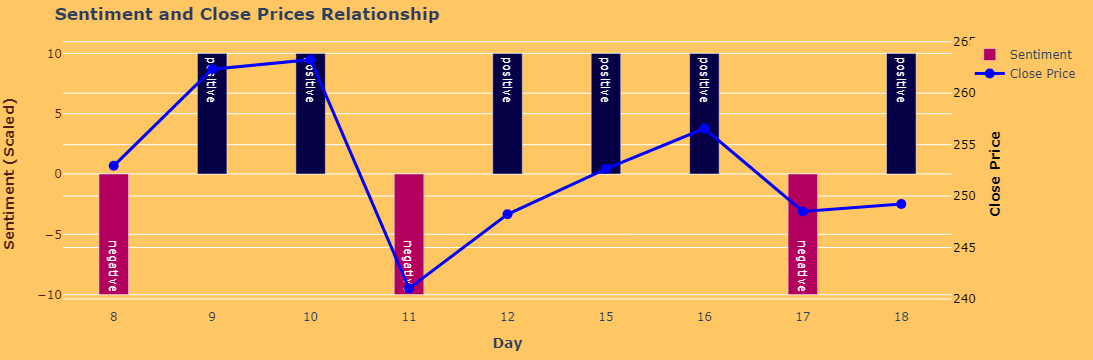

In [30]:
merged_df = merged_df.toPandas()
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df['day'] = merged_df['Date'].dt.day

# Encoding sentiments 
sentiment_mapping = {'negative': -1, 'positive': 1}
merged_df['sentiment_encoded'] = merged_df['overall_sentiment'].map(sentiment_mapping)

# Ensuring 'Close' column is numeric
merged_df['Close'] = pd.to_numeric(merged_df['Close'], errors='coerce')
bar_width = 0.3


# Creating the figure
fig = go.Figure()

# Adding bar plot for sentiments
fig.add_trace(go.Bar(
    x=merged_df['day'].astype(str),
    y=merged_df['sentiment_encoded'] * 10,  # Scale sentiment for better visualization
    marker_color=merged_df['overall_sentiment'].map({'negative': '#B3005E', 'positive': '#060047'}),
    name='Sentiment',
    text=merged_df['overall_sentiment'],
    textposition='inside',
    width=bar_width,
    yaxis='y1'
))

# Adding line plot for Close prices
fig.add_trace(go.Scatter(
    x=merged_df['day'].astype(str),
    y=merged_df['Close'],
    mode='lines+markers',
    name='Close Price',
    line=dict(color='blue', width=3),
    marker=dict(size=10, color='blue'),
    text=merged_df['Close'].apply(lambda x: f'{x:.2f}' if pd.notna(x) else 'N/A'),
    textposition='top center',
    yaxis='y2'
))

# Updating layout
fig.update_layout(
    title='<b>Sentiment and Close Prices Relationship</b>',
    xaxis_title='<b>Day</b>',
    yaxis_title='<b>Sentiment (Scaled)</b>',
    yaxis=dict(
        title='<b>Sentiment (Scaled)</b>',
        titlefont=dict(color='#4F200D'),
        tickfont=dict(color='#4F200D'),
        showgrid=True,
        zeroline=False
    ),
    yaxis2=dict(
        title='<b>Close Price</b>',
        titlefont=dict(color='#000000'),
        tickfont=dict(color='#000000'),
        overlaying='y',
        side='right'
    ),
    margin=dict(l=40, r=40, t=40, b=40),
    showlegend=True,
    plot_bgcolor='#FFC764',
    paper_bgcolor='#FFC764'
)

# Adding hover data widget
fig.update_traces(
    selector=dict(type='scatter'),
    hovertemplate='Day: %{x}<br>Close Price: %{y:.2f}<extra></extra>'
)
fig.update_traces(
    selector=dict(type='bar'),
    hovertemplate='Day: %{x}<br>Sentiment: %{text}<extra></extra>'
)

# Showingthe plot
fig.show()